<a href="https://colab.research.google.com/github/Alfikriangelo/MachineLearningTasks/blob/main/6thWeekTask/Dendograms%26HierarchicalClustering_OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dendograms**

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist, squareform

plt.rcParams['figure.figsize'] = [9, 5]
sns.set_theme()

In [4]:
# Menggunakan 10.000 baris pertama
data = pd.read_excel('sample_data/Online Retail.xlsx', nrows=20000)

# Menampilkan 5 baris pertama data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Hitung TotalPrice dan tambahkan kolom Kategori
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Tentukan threshold untuk kategori "Tinggi" dan "Rendah"
threshold = 50
data['Kategori'] = np.where(data['TotalPrice'] >= threshold, 'Tinggi', 'Rendah')

# Keep only petal length and petal width
data_df_sub = data.filter(
    items=[
        'Quantity',
        'UnitPrice',
        'Kategori'
    ]
)
# Subset dataset to two columns for easier
# visual inspection
numer_cols = ['Quantity', 'UnitPrice']

# Drop duplicates that have appeared
# due to removing columns
data_df_sub = data_df_sub.drop_duplicates().reset_index(drop=True)

# Reduce dataset for easier dendrogram preview
data_df_sub = data.groupby('Kategori').sample(3, random_state=44).reset_index(drop=True)

In [6]:
data_df_sub

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Kategori
0,537868,22624,IVORY KITCHEN SCALES,2,2010-12-08 16:49:00,8.50,12433.0,Norway,17.00,Rendah
1,537842,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2010-12-08 15:12:00,1.69,13140.0,United Kingdom,13.52,Rendah
2,537769,21181,PLEASE ONE PERSON METAL SIGN,1,2010-12-08 12:17:00,2.10,15021.0,United Kingdom,2.10,Rendah
3,536851,22503,CABIN BAG VINTAGE PAISLEY,6,2010-12-03 09:49:00,29.95,12967.0,United Kingdom,179.70,Tinggi
4,537603,22633,HAND WARMER UNION JACK,36,2010-12-07 12:49:00,2.10,14673.0,United Kingdom,75.60,Tinggi
5,536839,21524,DOORMAT SPOTTY HOME SWEET HOME,10,2010-12-02 18:25:00,6.75,15093.0,United Kingdom,67.50,Tinggi


Text(0.5, 1.0, 'data subset')

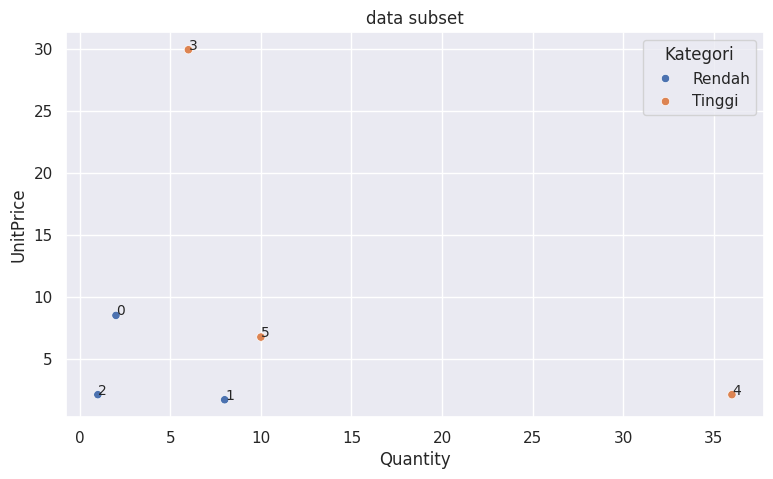

In [7]:
# Plot 'petal length (cm)' and 'petal width (cm)' with
# cluster info and point idx
sns.scatterplot(data_df_sub, x='Quantity', y='UnitPrice',hue='Kategori')
for idx in data_df_sub.index:
    plt.text(
        x=data_df_sub.loc[idx,'Quantity']+0.03,
        y=data_df_sub.loc[idx,'UnitPrice'],
        s=str(idx),
        size='small'
    )

plt.title('data subset')

In [8]:
linkage_matrix = linkage(data_df_sub[numer_cols], method='ward')
linkage_matrix

array([[ 1.        ,  5.        ,  5.44091904,  2.        ],
       [ 0.        ,  2.        ,  6.4776539 ,  2.        ],
       [ 6.        ,  7.        , 10.71600672,  4.        ],
       [ 3.        ,  8.        , 31.87722949,  5.        ],
       [ 4.        ,  9.        , 40.73530827,  6.        ]])

In [9]:
linkage_df = pd.DataFrame(linkage_matrix, columns=['First group', 'Second group', 'Distance', 'Size'])
linkage_df['New id'] = np.arange(linkage_df.shape[0]) + linkage_df.shape[0]+1

linkage_df

,First group,Second group,Distance,Size,New id
0,1.0,5.0,5.440919,2.0,6
1,0.0,2.0,6.477654,2.0,7
2,6.0,7.0,10.716007,4.0,8
3,3.0,8.0,31.877229,5.0,9
4,4.0,9.0,40.735308,6.0,10


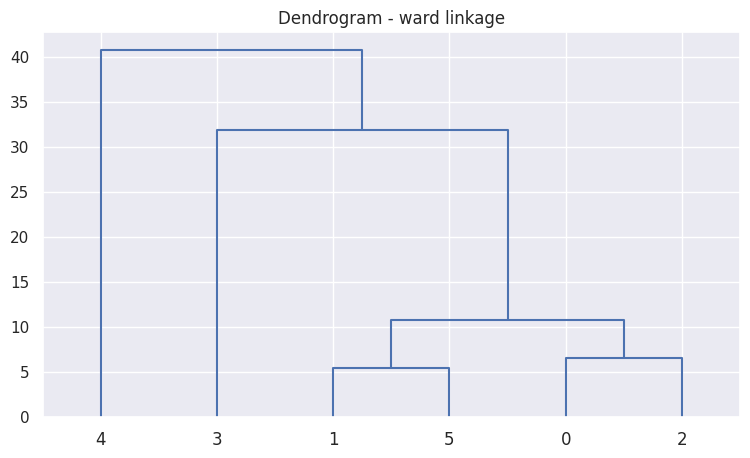

In [10]:
plt.figure()
dendrogram(linkage_matrix, color_threshold=4)
plt.title('Dendrogram - ward linkage')
plt.show()

# **Cophenetic Correlation Coefficient in Hierarchical Clustering**

The cophenetic correlation coefficient is a metric used to assess how accurately a dendrogram preserves the pairwise distances between the original data points. It is computed as the Pearson correlation coefficient between the original pairwise distances and the cophenetic distances obtained from the dendrogram.

In [11]:
cophenet(linkage_matrix, pdist(data_df_sub[numer_cols].to_numpy()))[0]

0.9553187433091959

In [12]:
def cophenetic_corr(linkage_matrix, data_mtx, distance_measure='euclidean'):

    if distance_measure != 'precomputed':
        cop_corr = cophenet(
            linkage_matrix,
            pdist(data_mtx, metric=distance_measure),
        )[0]

    else:
        cop_corr = cophenet(
            linkage_matrix,
            squareform(data_mtx),
        )[0]

    print(
        'Cophenetic correlation : {}'.format(cop_corr)
    )

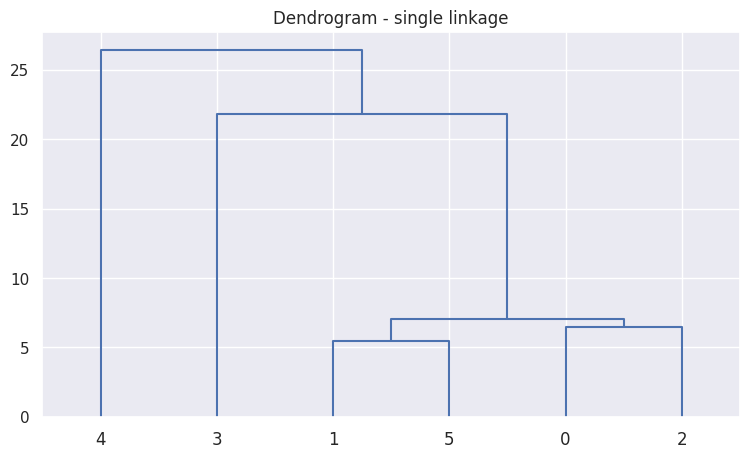

In [13]:
linkage_matrix = linkage(data_df_sub[numer_cols], method='single')

plt.figure()
dendrogram(linkage_matrix, color_threshold=4)
plt.title('Dendrogram - single linkage')
plt.show()

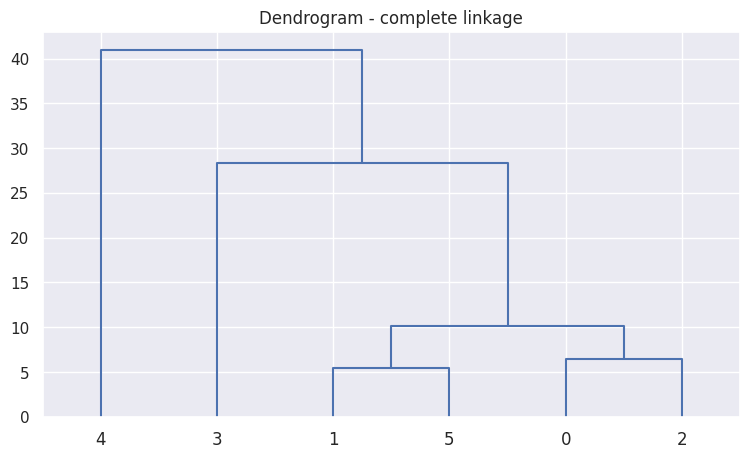

In [14]:
linkage_matrix = linkage(data_df_sub[numer_cols], method='complete')

plt.figure()
dendrogram(linkage_matrix, color_threshold=4)
plt.title('Dendrogram - complete linkage')
plt.show()

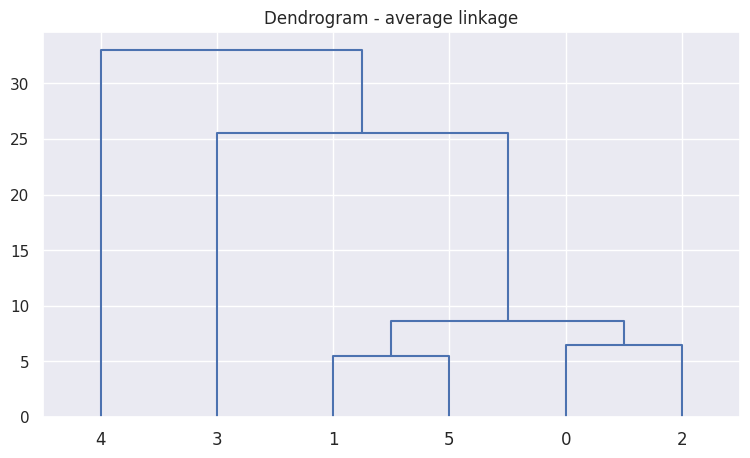

In [15]:
linkage_matrix = linkage(data_df_sub[numer_cols], method='average')

plt.figure()
dendrogram(linkage_matrix, color_threshold=4)
plt.title('Dendrogram - average linkage')
plt.show()

# **Dendrograms - Full Dataset**

In [16]:
# Hapus data dengan nilai negatif pada kolom Quantity dan UnitPrice
data = data[(data['Quantity'] >= 0) & (data['UnitPrice'] >= 0)]

# Hitung TotalPrice dan tambahkan kolom Kategori
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Tentukan threshold untuk kategori "Tinggi" dan "Rendah"
threshold = 50
data['Kategori'] = np.where(data['TotalPrice'] >= threshold, 'Tinggi', 'Rendah')

# Hitung TotalPrice dan tambahkan kolom Kategori
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Tentukan threshold untuk kategori "Tinggi" dan "Rendah"
threshold = 50
data['Kategori'] = np.where(data['TotalPrice'] >= threshold, 'Tinggi', 'Rendah')


<ipython-input-16-98b0ae6fea3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
<ipython-input-16-98b0ae6fea3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Kategori'] = np.where(data['TotalPrice'] >= threshold, 'Tinggi', 'Rendah')
<ipython-input-16-98b0ae6fea3b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Text(0.5, 1.0, 'Scatterplot with true kategori')

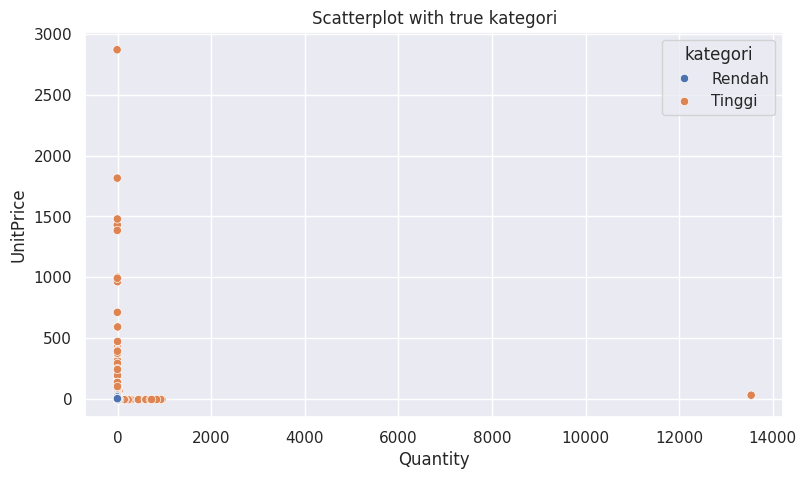

In [17]:
# Run PCA so we can show dataset in 2D space
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data[numer_cols].values)
pca_data = np.column_stack([pca_data, data['Kategori'].values])
pca_df = pd.DataFrame(pca_data, columns=['Quantity', 'UnitPrice', 'kategori'])

# Plot and colour based on reference label
sns.scatterplot(pca_df, x='Quantity', y='UnitPrice', hue='kategori')
plt.title('Scatterplot with true kategori')

Cophenetic correlation : 0.949802004142449


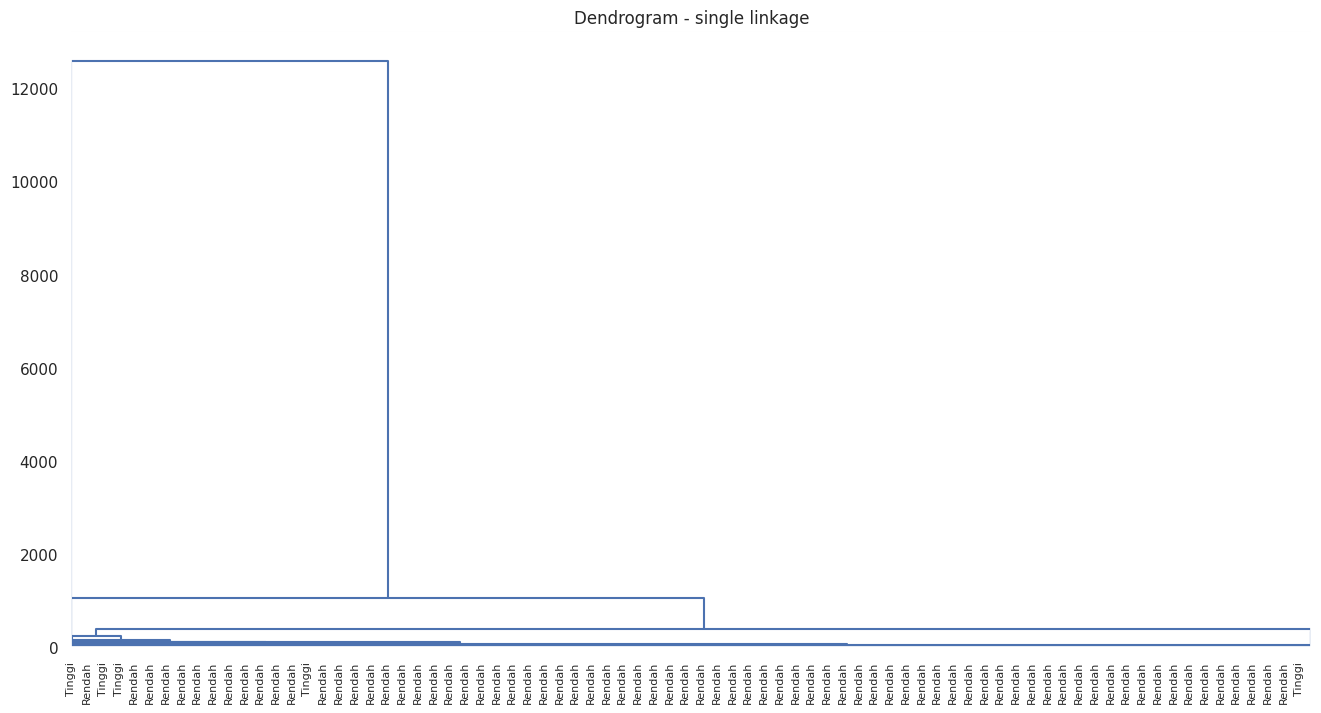

In [18]:
# Membuat linkage matrix
linkage_matrix = linkage(data[numer_cols], method='single')

# Menghitung koefisien kophenetik (tidak ada perubahan di sini)
cophenetic_corr(linkage_matrix, data[numer_cols].to_numpy())

# Membuat plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram_plot = dendrogram(linkage_matrix, color_threshold=1, labels=data['Kategori'].to_numpy(), leaf_font_size=8)

# Menyembunyikan sebagian besar label pada sumbu x
# Misalkan, hanya tampilkan setiap 50 label pada sumbu x
n = 250  # interval untuk menampilkan label
ax = plt.gca()
labels = ax.get_xmajorticklabels()
for i, label in enumerate(labels):
    if i % n != 0:
        label.set_visible(False)

# Judul dan tampilan plot
plt.title('Dendrogram - single linkage')
plt.show()

Text(0.5, 1.0, 'Scatterplot with true Kategori')

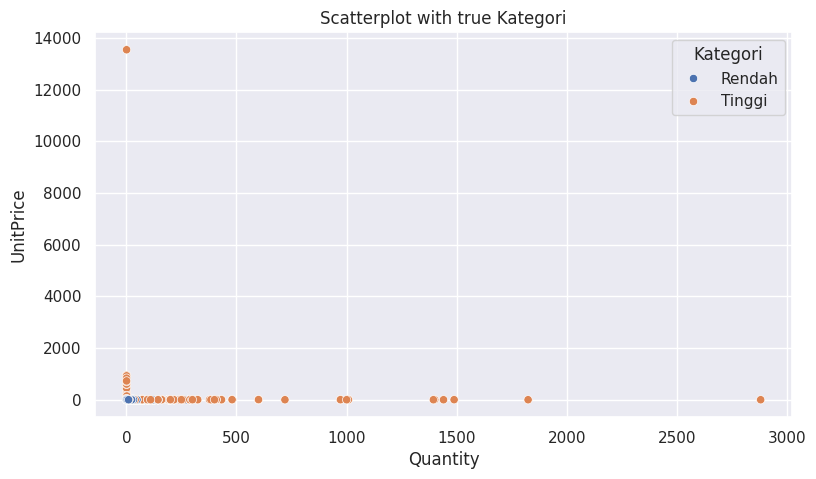

In [19]:
# Plot and colour based on reference label
sns.scatterplot(data, x='Quantity', y='UnitPrice', hue='Kategori')
plt.title('Scatterplot with true Kategori')

Cophenetic correlation : 0.96342913458046


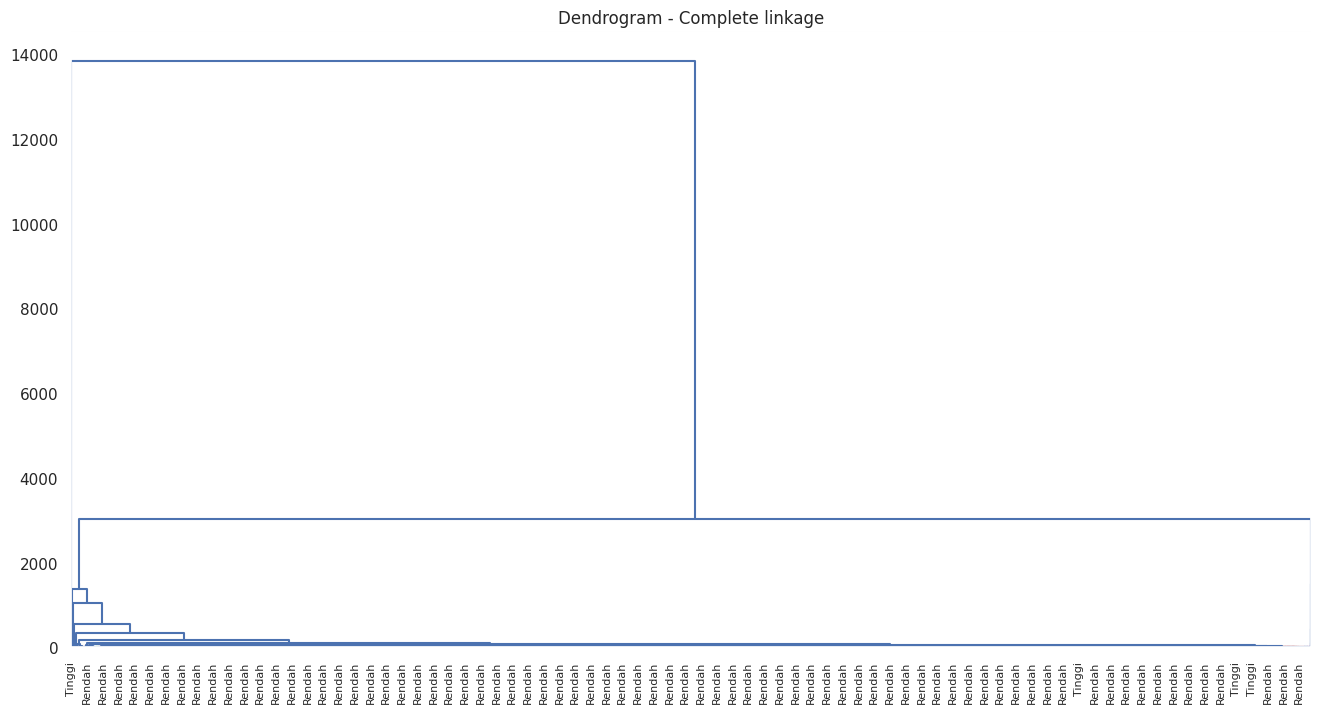

In [20]:
linkage_matrix = linkage(data[numer_cols], method='complete')
cophenetic_corr(linkage_matrix, data[numer_cols].to_numpy())

# Membuat plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram_plot = dendrogram(linkage_matrix, color_threshold=4, labels=data['Kategori'].to_numpy(), leaf_font_size=8)

# Menyembunyikan sebagian besar label pada sumbu x
# Misalkan, hanya tampilkan setiap 50 label pada sumbu x
n = 250  # interval untuk menampilkan label
ax = plt.gca()
labels = ax.get_xmajorticklabels()
for i, label in enumerate(labels):
    if i % n != 0:
        label.set_visible(False)

# Judul dan tampilan plot
plt.title('Dendrogram - Complete linkage')
plt.show()

Cophenetic correlation : 0.9927596588383731


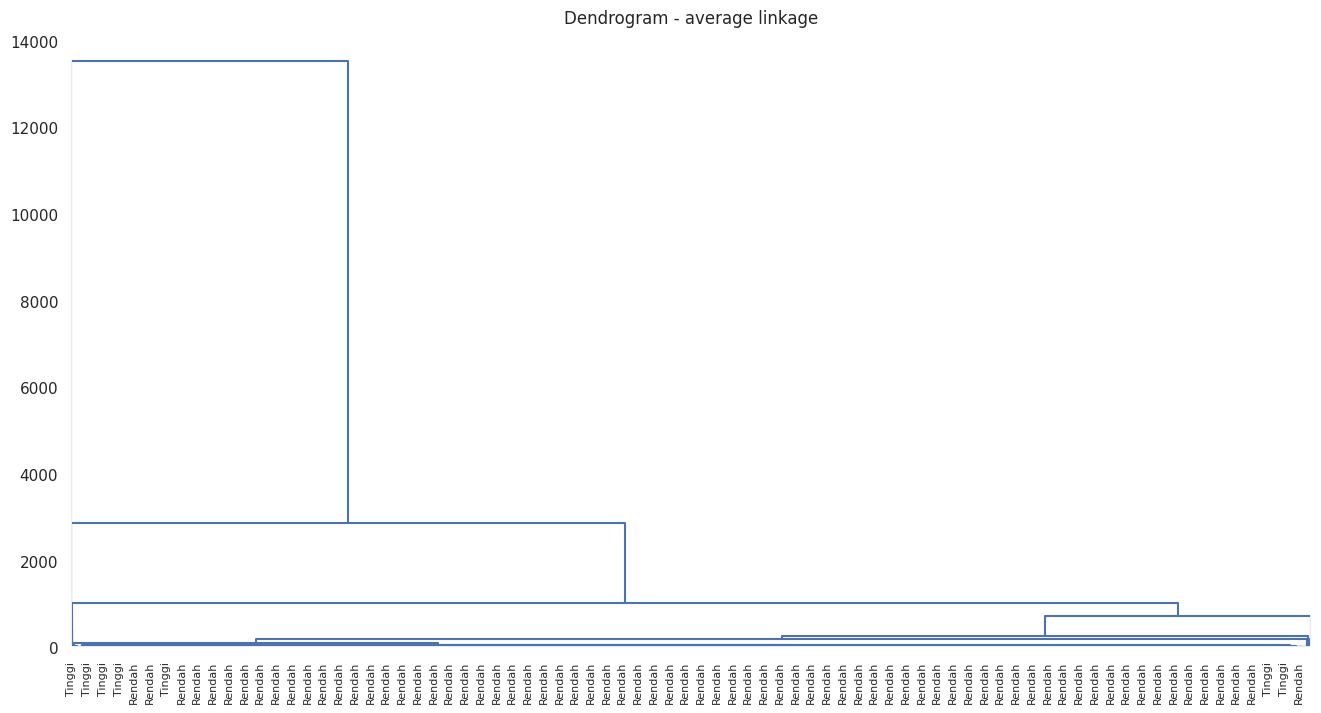

In [21]:
linkage_matrix = linkage(data[numer_cols], method='average')
cophenetic_corr(linkage_matrix, data[numer_cols].to_numpy())

# Membuat plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram_plot = dendrogram(linkage_matrix, color_threshold=4, labels=data['Kategori'].to_numpy(), leaf_font_size=8)

# Menyembunyikan sebagian besar label pada sumbu x
# Misalkan, hanya tampilkan setiap 50 label pada sumbu x
n = 250  # interval untuk menampilkan label
ax = plt.gca()
labels = ax.get_xmajorticklabels()
for i, label in enumerate(labels):
    if i % n != 0:
        label.set_visible(False)

# Judul dan tampilan plot
plt.title('Dendrogram - average linkage')
plt.show()

Cophenetic correlation : 0.4570041714776139


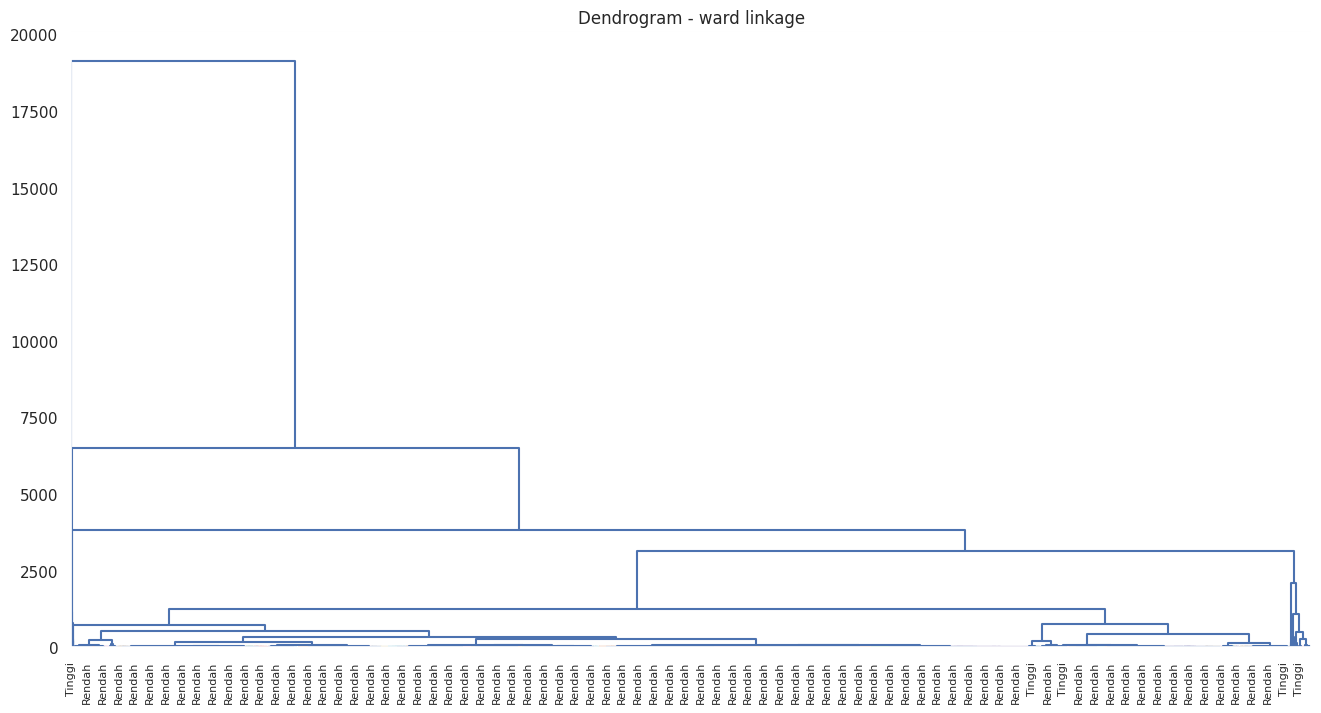

In [22]:
linkage_matrix = linkage(data[numer_cols], method='ward')
cophenetic_corr(linkage_matrix, data[numer_cols].to_numpy())

# Membuat plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram_plot = dendrogram(linkage_matrix, color_threshold=10, labels=data['Kategori'].to_numpy(), leaf_font_size=8)

# Menyembunyikan sebagian besar label pada sumbu x
# Misalkan, hanya tampilkan setiap 50 label pada sumbu x
n = 250  # interval untuk menampilkan label
ax = plt.gca()
labels = ax.get_xmajorticklabels()
for i, label in enumerate(labels):
    if i % n != 0:
        label.set_visible(False)

# Judul dan tampilan plot
plt.title('Dendrogram - ward linkage')
plt.show()

# **Dendrogram truncation**

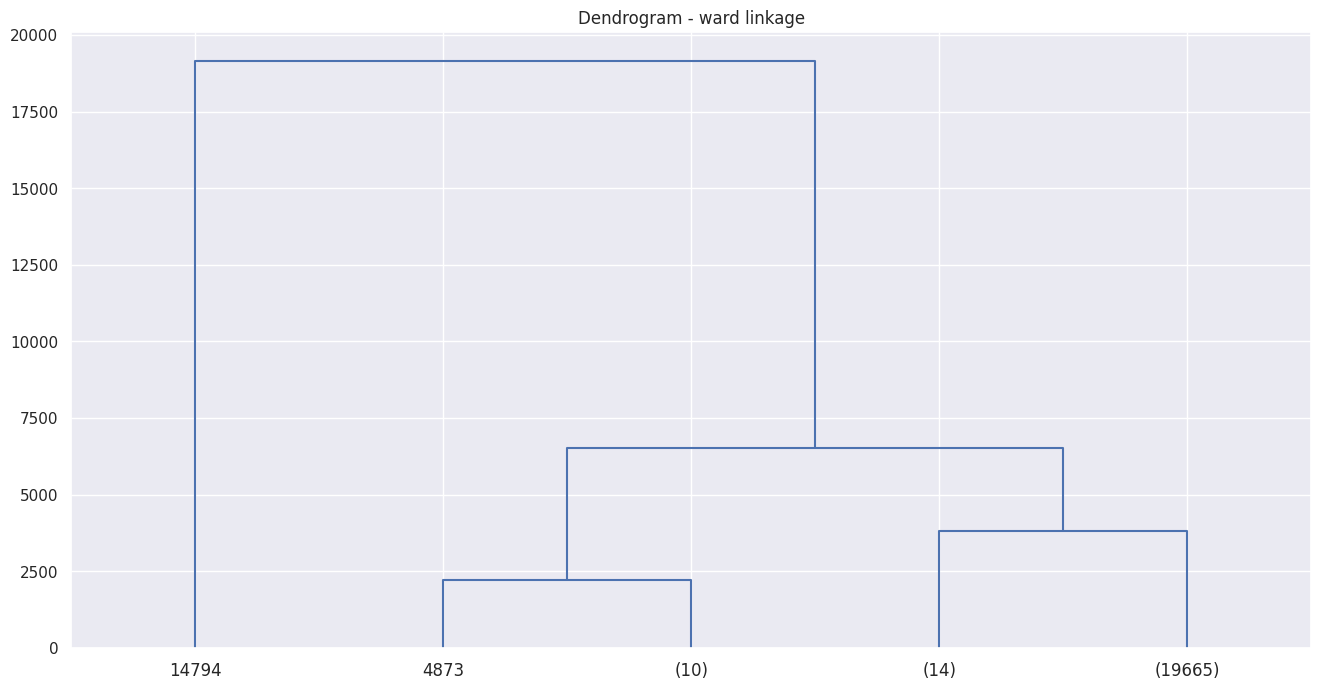

In [23]:
# Truncated dendrogram
linkage_matrix = linkage(data[numer_cols], method='ward')

plt.figure(figsize=(16,8))
dendrogram(linkage_matrix, color_threshold=4, truncate_mode="level", p=2)
plt.title('Dendrogram - ward linkage')
plt.show()



# **Evaluation Matrix**

In [24]:
pip install kneed

In [25]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
from kneed import KneeLocator

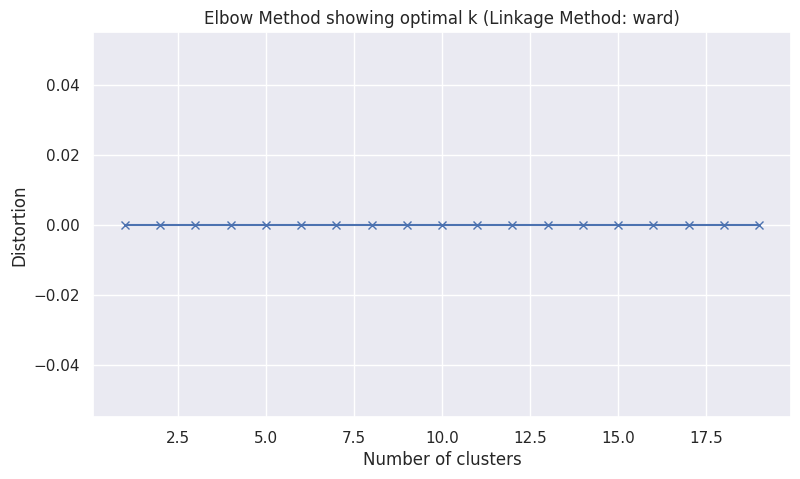

/usr/local/lib/python3.10/dist-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))


Optimal number of clusters (knee point): None


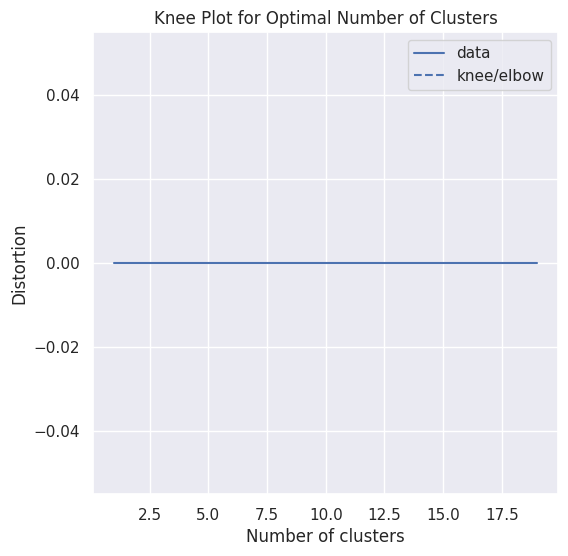

In [26]:
# --- Knee Point / Elbow Method (to determine optimal number of clusters) ---
def plot_elbow_method(data, linkage_method='ward'):
    distortions = []
    K = range(1, 20)

    for k in K:
        linkage_matrix = linkage(data, method=linkage_method)
        distortions.append(linkage_matrix[k-1][2])  # Distance metric for elbow

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(f'Elbow Method showing optimal k (Linkage Method: {linkage_method})')
    plt.show()

    # Find knee point using KneeLocator
    kneedle = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    print("Optimal number of clusters (knee point):", kneedle.elbow)
    kneedle.plot_knee()
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(f'Knee Plot for Optimal Number of Clusters')
    plt.show()

# Example usage on dataset
plot_elbow_method(data[numer_cols], linkage_method='ward')

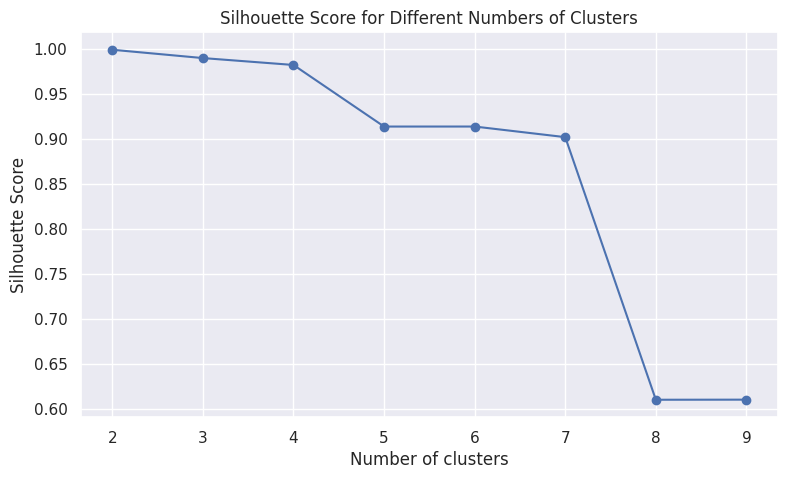

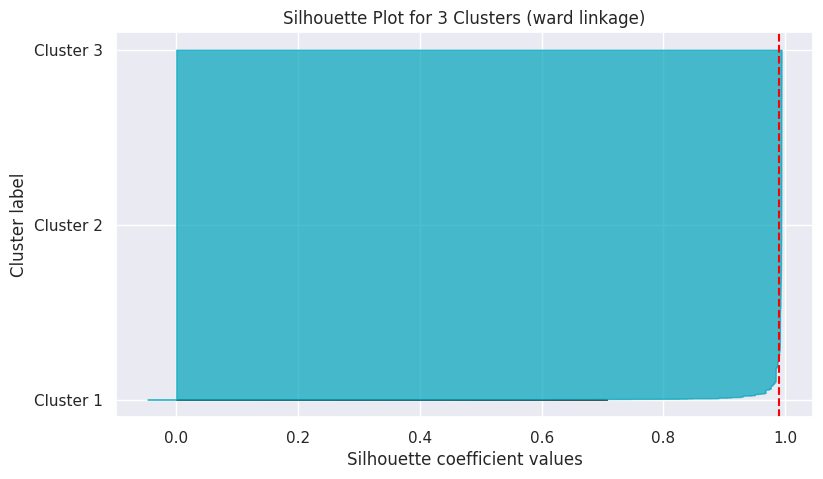

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, fcluster

def plot_silhouette(data, num_clusters, linkage_method='ward'):
    linkage_matrix = linkage(data, method=linkage_method)
    labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust') - 1

    # Compute silhouette scores for each sample
    silhouette_vals = silhouette_samples(data, labels)
    silhouette_avg = silhouette_score(data, labels)

    y_lower, y_upper = 0, 0
    yticks = []
    for i in range(num_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[labels == i]
        ith_cluster_silhouette_vals.sort()
        y_upper += len(ith_cluster_silhouette_vals)
        color = cm.nipy_spectral(float(i) / num_clusters)

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        yticks.append((y_lower + y_upper) / 2)
        y_lower = y_upper

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title(f"Silhouette Plot for {num_clusters} Clusters ({linkage_method} linkage)")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.yticks(yticks, [f'Cluster {i+1}' for i in range(num_clusters)])
    plt.show()

# Calculate silhouette scores for different cluster numbers
num_clusters_list = range(2, 10)
silhouette_score_list = []

for n_clusters in num_clusters_list:
    linkage_matrix = linkage(data[numer_cols], method='ward')
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    silhouette_avg = silhouette_score(data[numer_cols], labels)
    silhouette_score_list.append(silhouette_avg)

# Plot overall silhouette scores
plt.plot(num_clusters_list, silhouette_score_list, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Example silhouette plot for 3 clusters
plot_silhouette(data[numer_cols], num_clusters=3, linkage_method='ward')

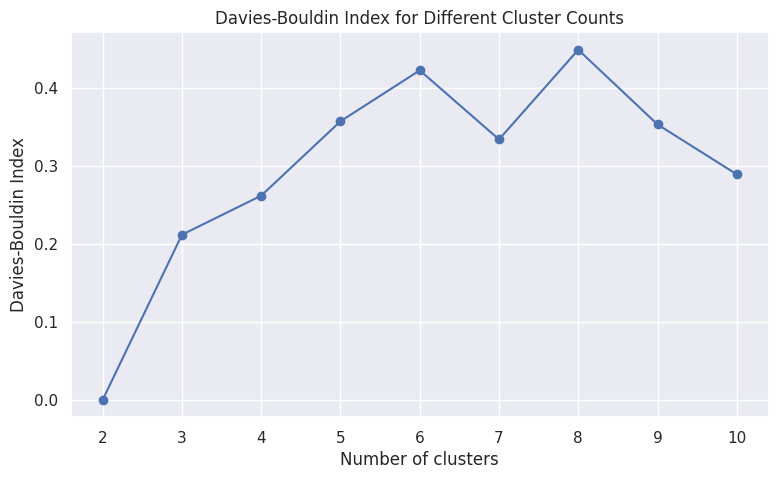

In [28]:
from sklearn.cluster import KMeans

def plot_davies_bouldin(data, max_clusters=10):
    db_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        db_index = davies_bouldin_score(data, labels)
        db_scores.append(db_index)

    plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
    plt.title("Davies-Bouldin Index for Different Cluster Counts")
    plt.xlabel("Number of clusters")
    plt.ylabel("Davies-Bouldin Index")
    plt.show()

# Example usage
plot_davies_bouldin(data[numer_cols], max_clusters=10)

In [29]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

# Select the number of clusters you want to evaluate
num_clusters = 3  # Example: 3 clusters

# Perform hierarchical clustering
linkage_matrix = linkage(data[numer_cols], method='ward')
labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust') - 1

# Calculate silhouette score
silhouette_avg = silhouette_score(data[numer_cols], labels)

# Print the silhouette score
print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg}")

Silhouette Score for 3 clusters: 0.9895699779509176


In [30]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

# Select the number of clusters you want to evaluate
num_clusters = 3  # Example: 3 clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(data[numer_cols])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(data[numer_cols], labels)

# Print the Davies-Bouldin Index
print(f"Davies-Bouldin Index for {num_clusters} clusters: {db_index}")

Davies-Bouldin Index for 3 clusters: 0.21214147911863565
